In [1]:
from curl_cffi import requests
import yfinance as yf
import pandas as pd
import numpy as np

# 1. Create a session using curl_cffi
session = requests.Session(impersonate="chrome")

# 2. Top 3 stocks from each GICS sector
tickers = [
    "AAPL", "MSFT", "NVDA",  # Technology
    "JNJ", "PFE", "UNH",     # Healthcare
    "JPM", "BAC", "WFC",     # Financials
    "XOM", "CVX", "COP",     # Energy
    "PG", "KO", "PEP",       # Consumer Staples
    "HD", "LOW", "TGT",      # Consumer Discretionary
    "NEE", "DUK", "SO",      # Utilities
    "GOOGL", "META", "DIS",  # Communication Services
    "UNP", "HON", "RTX",     # Industrials
    "SHW", "LIN", "FCX",     # Materials
    "AMT", "PLD", "EQIX"     # Real Estate
]

# 3. Download full multi-indexed data using the session
data = yf.download(
    tickers,
    start="2020-01-01",
    end="2024-12-31",
    group_by='ticker',
    auto_adjust=True,
    session=session
)

# 4. Extract adjusted-close (“Close” after auto_adjust=True) for all tickers
adj_close = pd.concat([data[t]['Close'] for t in tickers], axis=1)
adj_close.columns = tickers

# 5. Calculate daily returns
returns = adj_close.pct_change().dropna()

# 6. Split into train / validation / test by absolute dates
train_returns = returns.loc['2020-01-01':'2023-12-31']
val_returns   = returns.loc['2024-01-01':'2024-06-30']
test_returns  = returns.loc['2024-07-01':'2024-12-31']

# 7. (Optional) Save each split for downstream steps
train_returns.to_csv("train_returns.csv")
val_returns.to_csv("val_returns.csv")
test_returns.to_csv("test_returns.csv")

# 8. Equal-weight benchmark on the full-sample (for comparison later)
n_stocks = returns.shape[1]
equal_weights = np.ones(n_stocks) / n_stocks
equal_pf = returns.dot(equal_weights)

annual_return    = (1 + equal_pf.mean()) ** 252 - 1
annual_volatility = equal_pf.std() * np.sqrt(252)
risk_free_rate   = 0.02
sharpe_ratio     = (annual_return - risk_free_rate) / annual_volatility

print("Equal-Weighted Portfolio (2020–2024):")
print(f"  Annual Return:    {annual_return:.4%}")
print(f"  Annual Volatility: {annual_volatility:.4%}")
print(f"  Sharpe Ratio (2%): {sharpe_ratio:.4f}")


[*********************100%***********************]  33 of 33 completed


Equal-Weighted Portfolio (2020–2024):
  Annual Return:    18.4083%
  Annual Volatility: 21.3385%
  Sharpe Ratio (2%): 0.7690


In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp

# === 1. Load your splits ===
train_returns = pd.read_csv("train_returns.csv", index_col=0, parse_dates=True)
val_returns   = pd.read_csv("val_returns.csv",   index_col=0, parse_dates=True)
test_returns  = pd.read_csv("test_returns.csv",  index_col=0, parse_dates=True)

# === 2. Combine for rolling estimation & drop any assets with gaps ===
all_returns = pd.concat([train_returns, val_returns, test_returns])
all_returns = all_returns.dropna(axis=1)

# === 3. Define Parameters & Data classes (unchanged) ===
class Parameters:
    def __init__(self, n_assets):
        self.w_min = np.zeros(n_assets)
        self.w_max = np.ones(n_assets)
        self.c_min = -0.1
        self.c_max = 0.1
        self.L_tar = 1.0
        self.T_tar = 0.2
        self.z_min = -0.2 * np.ones(n_assets)
        self.z_max = 0.2 * np.ones(n_assets)
        self.gamma_hold = 0.01
        self.gamma_trade = 0.01
        self.risk_target = 0.04

class Data:
    def __init__(self, mean, cov, w_prev, kappa_short, kappa_borrow, kappa_spread, kappa_impact):
        self.mean = mean
        self.cov = cov
        self.w_prev = w_prev
        self.kappa_short = kappa_short
        self.kappa_borrow = kappa_borrow
        self.kappa_spread = kappa_spread
        self.kappa_impact = kappa_impact

# Global DCP‐failure counter
dcp_fail_count = 0

# === 4. Markowitz optimizer (same as before) ===
def markowitz(data: Data, param: Parameters, verbose=False):
    global dcp_fail_count
    n = param.w_min.shape[0]
    w, c = cp.Variable(n), cp.Variable()
    z = w - data.w_prev
    T = cp.norm1(z) / 2
    L = cp.norm1(w)

    risk = cp.quad_form(w, data.cov)
    ret  = w.T @ data.mean

    holding_cost = data.kappa_short @ cp.pos(-w) + data.kappa_borrow * cp.pos(-c)
    trading_cost = data.kappa_spread @ cp.abs(z) + data.kappa_impact @ cp.power(cp.abs(z), 1.5)

    objective = ret - param.gamma_hold * holding_cost - param.gamma_trade * trading_cost
    constraints = [
        cp.sum(w) + c == 1,
        param.w_min <= w, w <= param.w_max,
        L <= param.L_tar,
        param.c_min <= c, c <= param.c_max,
        param.z_min <= z, z <= param.z_max,
        T <= param.T_tar,
        risk <= param.risk_target
    ]

    prob = cp.Problem(cp.Maximize(objective), constraints)
    if not prob.is_dcp():
        dcp_fail_count += 1
        if verbose: print("DCP check failed.")
        return None

    try:
        prob.solve()
        return w.value
    except Exception as e:
        if verbose: print("Solver error:", e)
        return None

# === 5. Rolling‐window rebalance simulator ===
def simulate_markowitz_rebalancing(returns, rebalance_freq='M', lookback=60):
    returns = returns.dropna(axis=1)
    dates = returns.index
    n_assets = returns.shape[1]

    w_prev = np.ones(n_assets) / n_assets
    portfolio_returns = []

    # fixed cost parameters
    kappa_short  = 0.001 * np.ones(n_assets)
    kappa_borrow = 0.001
    kappa_spread = 0.005 * np.ones(n_assets)
    kappa_impact = 0.01 * np.ones(n_assets)
    param = Parameters(n_assets)

    for i in range(lookback, len(dates)):
        date = dates[i]
        do_reb = (
            rebalance_freq == 'D' or
            (rebalance_freq == 'W' and date.weekday() == 0) or
            (rebalance_freq == 'M' and date.day == 1)
        )
        if do_reb:
            window = returns.iloc[i - lookback:i]
            mu  = window.mean().values * 252
            cov = window.cov().values * 252
            data = Data(mu, cov, w_prev, kappa_short, kappa_borrow, kappa_spread, kappa_impact)
            w_opt = markowitz(data, param)
            if w_opt is not None:
                w_prev = w_opt

        portfolio_returns.append(returns.iloc[i].values @ w_prev)

    return pd.Series(portfolio_returns, index=dates[lookback:])

# === 6. Run on full history, then slice out test period ===
mvo_daily  = simulate_markowitz_rebalancing(all_returns, 'D')
mvo_weekly = simulate_markowitz_rebalancing(all_returns, 'W')
mvo_monthly= simulate_markowitz_rebalancing(all_returns, 'M')

test_start, test_end = test_returns.index[0], test_returns.index[-1]
mvo_daily_test   = mvo_daily.loc[test_start:test_end]
mvo_weekly_test  = mvo_weekly.loc[test_start:test_end]
mvo_monthly_test = mvo_monthly.loc[test_start:test_end]

# === 7. Compute test‐period metrics robustly ===
def metrics_with_sharpe(r):
    ann_ret = (1 + r.mean()) ** 252 - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

# List of (name, return‐series) tuples
strategies = [
    ("MVO Daily",   mvo_daily_test),
    ("MVO Weekly",  mvo_weekly_test),
    ("MVO Monthly", mvo_monthly_test),
]

# Compute metrics for each
results = []
for name, series in strategies:
    ann, vol, sr = metrics_with_sharpe(series)
    results.append({
        "Strategy":          name,
        "Annual Return":     ann,
        "Annual Volatility": vol,
        "Sharpe Ratio":      sr
    })

# Build DataFrame
metrics_test = pd.DataFrame(results).set_index("Strategy")

print(metrics_test)
print(f"Total DCP failures: {dcp_fail_count}")



e:\Anaconda\envs\ml2023\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
e:\Anaconda\envs\ml2023\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
e:\Anaconda\envs\ml2023\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


             Annual Return  Annual Volatility  Sharpe Ratio
Strategy                                                   
MVO Daily         0.134038           0.190503      0.703598
MVO Weekly        0.052431           0.197390      0.265622
MVO Monthly       0.183185           0.220397      0.831163
Total DCP failures: 0


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# === 1. Load your splits ===
train_df = pd.read_csv("train_returns.csv", index_col=0, parse_dates=True)
val_df   = pd.read_csv("val_returns.csv",   index_col=0, parse_dates=True)
test_df  = pd.read_csv("test_returns.csv",  index_col=0, parse_dates=True)

# Align columns and drop any with missing data in train
train_df = train_df.dropna(axis=1)
assets = train_df.columns.tolist()
val_df   = val_df[assets].dropna(axis=0)
test_df  = test_df[assets].dropna(axis=0)

# === 2. Scale returns to [0,1] ===
scaler = MinMaxScaler()
scaler.fit(train_df.values)
train_scaled = scaler.transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

# === 3. Create sequences ===
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_val, y_val     = create_sequences(
    np.vstack([train_scaled[-lookback:], val_scaled]),
    lookback
)
X_test, y_test   = create_sequences(
    np.vstack([val_scaled[-lookback:], test_scaled]),
    lookback
)

# === 4. PyTorch Dataset and DataLoader ===
class ReturnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_loader = DataLoader(ReturnDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(ReturnDataset(X_val, y_val),     batch_size=batch_size)
test_loader  = DataLoader(ReturnDataset(X_test, y_test),   batch_size=batch_size)

# === 5. Define LSTM model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, input_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # take last time step
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=len(assets)).to(device)

# === 6. Training setup ===
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
patience, best_val_loss, counter = 5, float('inf'), 0

# === 7. Training loop with early stopping ===
for epoch in range(1, epochs+1):
    # Training
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            val_loss += criterion(output, y_batch).item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# === 8. Load best model and generate predictions ===
model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        predictions.append(preds)
pred_array = np.vstack(predictions)
pred_returns = scaler.inverse_transform(pred_array)

# === 9. Save predictions ===
pred_idx = test_df.index           # full H2 2024 index
pred_df  = pd.DataFrame(pred_returns, index=pred_idx, columns=assets)
pred_df.to_csv("pred_returns.csv")



Epoch 1: Train Loss = 0.102157, Val Loss = 0.006253
Epoch 2: Train Loss = 0.005534, Val Loss = 0.002699
Epoch 3: Train Loss = 0.004288, Val Loss = 0.002588
Epoch 4: Train Loss = 0.004246, Val Loss = 0.002629
Epoch 5: Train Loss = 0.004256, Val Loss = 0.002569
Epoch 6: Train Loss = 0.004245, Val Loss = 0.002574
Epoch 7: Train Loss = 0.004241, Val Loss = 0.002610
Epoch 8: Train Loss = 0.004267, Val Loss = 0.002653
Epoch 9: Train Loss = 0.004299, Val Loss = 0.002583
Epoch 10: Train Loss = 0.004254, Val Loss = 0.002602
Early stopping triggered!


In [13]:
# === Step 1: ETF 对应行业 ===
sector_etfs = {
    "Technology": "XLK",
    "Healthcare": "XLV",
    "Financials": "XLF",
    "Energy": "XLE",
    "Consumer Staples": "XLP",
    "Consumer Discretionary": "XLY",
    "Utilities": "XLU",
    "Communication Services": "XLC",
    "Industrials": "XLI",
    "Materials": "XLB",
    "Real Estate": "XLRE"
}

# === Step 2: 股票 -> 行业 映射 ===
stock_sector_map = {
    "AAPL": "Technology", "MSFT": "Technology", "NVDA": "Technology",
    "JNJ": "Healthcare", "PFE": "Healthcare", "UNH": "Healthcare",
    "JPM": "Financials", "BAC": "Financials", "WFC": "Financials",
    "XOM": "Energy", "CVX": "Energy", "COP": "Energy",
    "PG": "Consumer Staples", "KO": "Consumer Staples", "PEP": "Consumer Staples",
    "HD": "Consumer Discretionary", "LOW": "Consumer Discretionary", "TGT": "Consumer Discretionary",
    "NEE": "Utilities", "DUK": "Utilities", "SO": "Utilities",
    "GOOGL": "Communication Services", "META": "Communication Services", "DIS": "Communication Services",
    "UNP": "Industrials", "HON": "Industrials", "RTX": "Industrials",
    "SHW": "Materials", "LIN": "Materials", "FCX": "Materials",
    "AMT": "Real Estate", "PLD": "Real Estate", "EQIX": "Real Estate"
}

# === Step 3: 下载 ETF 数据 ===
etf_tickers = list(sector_etfs.values())
etf_data = yf.download(etf_tickers, start="2020-01-01", end="2024-12-31", auto_adjust=True, session=session)
etf_prices = etf_data['Close']
etf_returns = etf_prices.pct_change().dropna()

# === Step 4: 滚动年化波动率 (21日窗口)
vol_window = 21
rolling_vol = etf_returns.rolling(window=vol_window).std() * np.sqrt(252)

# === Step 5: 计算 rolling z-score （每日）
zscore_daily = (rolling_vol - rolling_vol.mean()) / rolling_vol.std()
zscore_daily = zscore_daily.dropna()

# === Step 6: 提取每周（周一）、每月（1号）z-score
zscore_weekly = zscore_daily[zscore_daily.index.weekday == 0]
zscore_monthly = zscore_daily[zscore_daily.index.day == 1]

# === Step 7: 创建函数：将行业z-score映射到股票 ===
def map_zscore_to_stocks(zscore_df):
    result = {}
    for date, row in zscore_df.iterrows():
        mapped = {
            stock: row[sector_etfs[stock_sector_map[stock]]]
            for stock in stock_sector_map
        }
        result[date] = mapped
    return pd.DataFrame(result).T.sort_index()

# === Step 8: 映射成股票层面的情绪时间序列 ===
sentiment_daily = map_zscore_to_stocks(zscore_daily)
sentiment_weekly = map_zscore_to_stocks(zscore_weekly)
sentiment_monthly = map_zscore_to_stocks(zscore_monthly)

# === Step 9: 每一行进行 Min-Max 归一化（0~1）
def min_max_scale(df):
    return (df.T - df.min(axis=1)) / (df.max(axis=1) - df.min(axis=1) + 1e-8)  # 防除零
sentiment_daily = min_max_scale(sentiment_daily).T
sentiment_weekly = min_max_scale(sentiment_weekly).T
sentiment_monthly = min_max_scale(sentiment_monthly).T

# === Step 10: 保存 CSV（可选）
sentiment_daily.to_csv("sector_sentiment_daily_scaled.csv")
sentiment_weekly.to_csv("sector_sentiment_weekly_scaled.csv")
sentiment_monthly.to_csv("sector_sentiment_monthly_scaled.csv")

# === Step 11: 预览结果 ===
print("股票行业情绪 Min-Max 归一化 z-score 示例（每日）:")
print(sentiment_daily.head())


[*********************100%***********************]  11 of 11 completed


股票行业情绪 Min-Max 归一化 z-score 示例（每日）:
                AAPL      MSFT      NVDA  JNJ  PFE  UNH       JPM       BAC  \
2020-02-03  0.753419  0.753419  0.753419  1.0  1.0  1.0  0.769413  0.769413   
2020-02-04  0.720115  0.720115  0.720115  1.0  1.0  1.0  0.626133  0.626133   
2020-02-05  0.612883  0.612883  0.612883  1.0  1.0  1.0  0.646813  0.646813   
2020-02-06  0.617033  0.617033  0.617033  1.0  1.0  1.0  0.635214  0.635214   
2020-02-07  0.630912  0.630912  0.630912  1.0  1.0  1.0  0.614812  0.614812   

                 WFC       XOM  ...       DIS       UNP       HON       RTX  \
2020-02-03  0.769413  0.377867  ...  0.503076  0.798013  0.798013  0.798013   
2020-02-04  0.626133  0.253242  ...  0.377658  0.810112  0.810112  0.810112   
2020-02-05  0.646813  0.522992  ...  0.249634  0.779487  0.779487  0.779487   
2020-02-06  0.635214  0.527697  ...  0.309172  0.781315  0.781315  0.781315   
2020-02-07  0.614812  0.491891  ...  0.280283  0.783142  0.783142  0.783142   

               

In [14]:
# === Step 2: CVaR ===
def compute_cvar_series(returns_df, weights, window=21, alpha=0.05):
    """
    Compute rolling portfolio CVaR using a fixed lookback window.
    - returns_df: pd.DataFrame (daily asset returns)
    - weights: np.array (portfolio weights)
    - window: lookback window (default 21 days)
    - alpha: tail quantile (default 5%)
    """
    port_returns = returns_df @ weights
    cvar_series = port_returns.rolling(window=window).apply(
        lambda x: -np.mean(x[x < np.quantile(x, alpha)]) if len(x[x < np.quantile(x, alpha)]) > 0 else np.nan,
        raw=False
    )
    return cvar_series.dropna()

# === Step 3: set up same weight ===
n_assets = returns.shape[1]
equal_weights = np.ones(n_assets) / n_assets

# === Step 4: Daily CVaR（21 days）===
cvar_daily = compute_cvar_series(returns, equal_weights, window=21, alpha=0.05)

# === Step 5: 筛选每周/每月 ===
cvar_weekly = cvar_daily[cvar_daily.index.weekday == 0]
cvar_monthly = cvar_daily[cvar_daily.index.day == 1]

# === Step 6: DataFrame）===
cvar_df = pd.DataFrame({
    "CVaR_Daily": cvar_daily,
    "CVaR_Weekly": cvar_weekly,
    "CVaR_Monthly": cvar_monthly
})

cvar_df.to_csv("cvar_frequencies.csv")


print("CVaR 文件已保存: cvar_frequencies.csv")
print(cvar_df.head())

CVaR 文件已保存: cvar_frequencies.csv
            CVaR_Daily  CVaR_Weekly  CVaR_Monthly
Date                                             
2020-02-03    0.020745     0.020745           NaN
2020-02-04    0.020745          NaN           NaN
2020-02-05    0.020745          NaN           NaN
2020-02-06    0.020745          NaN           NaN
2020-02-07    0.020745          NaN           NaN


In [15]:
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# === Step 1: Download（S&P500） ===
sp500 = yf.download("^GSPC", start="2020-01-01", end="2024-12-31", auto_adjust=True)['Close']
sp500_returns = sp500.pct_change().dropna().values.reshape(-1, 1)

# === Step 2:  HMM  ===
model = GaussianHMM(n_components=3, covariance_type="full", random_state=42)
model.fit(sp500_returns)

# === Step 3: Daily probability of volatility（Low/Median/High）
state_probs = model.predict_proba(sp500_returns)
state_preds = model.predict(sp500_returns)

# === Step 4: DataFrame
dates = sp500.index[1:]  # drop first nan
hmm_df = pd.DataFrame(state_probs, columns=["Low_Vol", "Med_Vol", "High_Vol"], index=dates)
hmm_df["Regime_Label"] = state_preds


hmm_daily = hmm_df.copy()
hmm_weekly = hmm_df[hmm_df.index.weekday == 0]
hmm_monthly = hmm_df[hmm_df.index.day == 1]

hmm_daily.to_csv("hmm_states_daily.csv")
hmm_weekly.to_csv("hmm_states_weekly.csv")
hmm_monthly.to_csv("hmm_states_monthly.csv")

print("HMM Daily Volatility:")
print(hmm_daily.head())



[*********************100%***********************]  1 of 1 completed
e:\Anaconda\envs\ml2023\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


HMM Daily Volatility:
             Low_Vol   Med_Vol      High_Vol  Regime_Label
Date                                                      
2020-01-03  0.988551  0.011449  6.812180e-15             0
2020-01-06  0.011849  0.988142  8.988288e-06             1
2020-01-07  0.984131  0.015557  3.116907e-04             0
2020-01-08  0.015986  0.983896  1.173631e-04             1
2020-01-09  0.980068  0.019585  3.468418e-04             0


D-rebalance | 2020-01-01 to 2024-12-31 -> Return 39.89%, Vol 23.21%, Sharpe 1.63
W-rebalance | 2020-01-01 to 2024-12-31 -> Return 45.61%, Vol 26.37%, Sharpe 1.65
M-rebalance | 2020-01-01 to 2024-12-31 -> Return 50.83%, Vol 28.27%, Sharpe 1.73


<Figure size 1000x600 with 0 Axes>

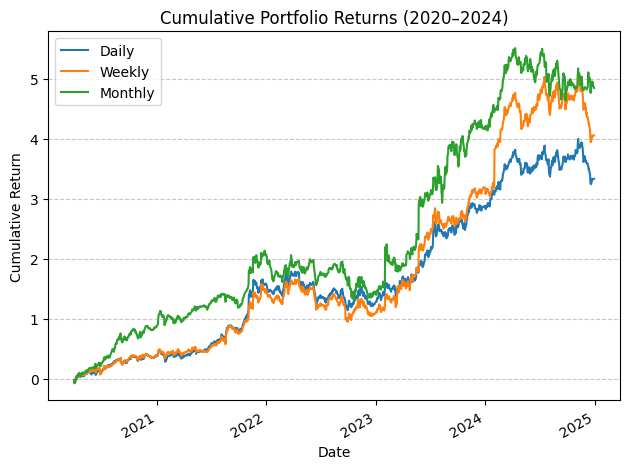

In [37]:
from sklearn.decomposition import PCA
# === Load Data ===
returns = pd.read_csv("sector_portfolio_returns.csv", index_col=0, parse_dates=True)
sentiment_daily   = pd.read_csv("sector_sentiment_daily_scaled.csv", index_col=0, parse_dates=True)
sentiment_weekly  = pd.read_csv("sector_sentiment_weekly_scaled.csv", index_col=0, parse_dates=True)
sentiment_monthly = pd.read_csv("sector_sentiment_monthly_scaled.csv", index_col=0, parse_dates=True)
cvar = pd.read_csv("cvar_frequencies.csv", index_col=0, parse_dates=True)
hmm_probs = pd.read_csv("hmm_states_daily.csv", index_col=0, parse_dates=True)[["Low_Vol","Med_Vol","High_Vol"]]
pred_returns = pd.read_csv("pred_returns.csv", index_col=0, parse_dates=True)

# === PCA for HMM volatility factor ===
pca = PCA(n_components=1)
vol_score = pd.Series(
    pca.fit_transform(hmm_probs).flatten(),
    index=hmm_probs.index
)
vol_score = (vol_score - vol_score.min()) / (vol_score.max() - vol_score.min())
vol_score_daily   = vol_score
vol_score_weekly  = vol_score[vol_score.index.weekday == 0]
vol_score_monthly = vol_score[vol_score.index.day == 1]

# === Test-period bounds ===
test_start = pd.to_datetime("2020-01-01")
test_end   = pd.to_datetime("2024-12-31")

# === DCP failure counter ===
dcp_failed_count = {"D": 0, "W": 0, "M": 0}

def markowitz_multifactor(mu, cov, w_prev, sentiment_vec, vol_score, cvar_scalar,
                          lambda_var=1.0, lambda_sent=10.0, lambda_hmm=5.0, lambda_cvar=50.0,
                          verbose=False, freq="D"):
    global dcp_failed_count
    n = len(mu)
    w = cp.Variable(n)
    expected_return = mu @ w
    variance_term   = lambda_var * cp.quad_form(w, cp.psd_wrap(cov))
    sentiment_term  = lambda_sent * cp.sum(cp.multiply(sentiment_vec, cp.square(w)))
    hmm_term        = lambda_hmm * vol_score * cp.sum_squares(w)
    cvar_term       = lambda_cvar * cvar_scalar
    obj = cp.Maximize(expected_return - variance_term - sentiment_term - hmm_term - cvar_term)
    constraints = [cp.sum(w) == 1, w >= 0, w <= 1]
    prob = cp.Problem(obj, constraints)
    if not prob.is_dcp():
        dcp_failed_count[freq] += 1
        return None, None
    prob.solve()
    if w.value is None:
        dcp_failed_count[freq] += 1
        return None, None
    penalties = {
        "variance": variance_term.value,
        "sentiment": sentiment_term.value,
        "hmm": hmm_term.value,
        "cvar": cvar_term
    }
    return w.value, penalties

def simulate_portfolio(returns, sentiment, vol_score, cvar_series, pred_df, rebalance_freq='M', lookback=60):
    returns = returns.dropna(axis=1)
    sentiment = sentiment[returns.columns]
    dates = returns.index
    # compute boolean masks for “first trading day of period”
    period = dates.to_series()
    is_month_start = period.dt.to_period('M').ne(period.dt.to_period('M').shift())
    is_week_start  = period.dt.to_period('W').ne(period.dt.to_period('W').shift())

    n_assets = returns.shape[1]
    w_prev = np.ones(n_assets) / n_assets
    port_rets = []
    penalty_logs = []
    rebalance_dates = []

    for i in range(lookback, len(dates)):
        date = dates[i]
        # Rebalance check
        if rebalance_freq == 'M' and not is_month_start.loc[date]:
            port_rets.append(returns.iloc[i].values @ w_prev)
            continue
        if rebalance_freq == 'W' and not is_week_start.loc[date]:
            port_rets.append(returns.iloc[i].values @ w_prev)
            continue

        window = returns.iloc[i-lookback:i]
        cov = window.cov().values * 252

        # Use LSTM prediction if available, else fallback to history
        if date in pred_df.index:
            mu = pred_df.loc[date].values * 252
        else:
            mu = window.mean().values * 252

        try:
            sent_vec = sentiment.loc[date].values
            vol_s   = vol_score.loc[date]
            cvar_s  = cvar_series.loc[date]
        except KeyError:
            port_rets.append(returns.iloc[i].values @ w_prev)
            continue

        w_opt, pen = markowitz_multifactor(mu, cov, w_prev, sent_vec, vol_s, cvar_s,
                                           freq=rebalance_freq)
        if w_opt is not None:
            w_prev = w_opt
            rebalance_dates.append(date)
            penalty_logs.append(pen)
        port_rets.append(returns.iloc[i].values @ w_prev)

    return pd.Series(port_rets, index=dates[lookback:]), penalty_logs, rebalance_dates

# Performance Metrics
def performance_metrics(r, risk_free_rate=0.02):
    if len(r) == 0 or r.isnull().all():
        return np.nan, np.nan, np.nan
    ann_return = (1 + r.mean())**252 - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe_ratio = (ann_return - risk_free_rate) / ann_vol
    return ann_return, ann_vol, sharpe_ratio

# Simplified penalty summary
def summarize_penalties(penalty_dicts, label):
    if not penalty_dicts:
        print(f"{label}: no penalty data")
        return
    df = pd.DataFrame(penalty_dicts)
    mean_pen = df.abs().mean().sort_values(ascending=False)
    print(f"\n{label} - Avg |Penalty|:")
    print(mean_pen)

# === Test‐period bounds ===
# Now covering the full sample
test_start = pd.to_datetime("2020-01-01")
test_end   = pd.to_datetime("2024-12-31")

# Prepare a fresh dict to collect slices
test_returns = {}

# === Run backtests and slice to [2020-01-01, 2024-12-31] ===
for freq, sentiment, vol in zip(
    ['D', 'W', 'M'],
    [sentiment_daily, sentiment_weekly, sentiment_monthly],
    [vol_score_daily, vol_score_weekly, vol_score_monthly]
):
    cvar_col = f"CVaR_{'Daily' if freq=='D' else 'Weekly' if freq=='W' else 'Monthly'}"

    # 1) Full history
    r_full, logs_full, dates_full = simulate_portfolio(
        returns,
        sentiment,
        vol,
        cvar[cvar_col],
        pred_returns,
        rebalance_freq=freq,
        lookback=60
    )

    # 2) Slice to the new "test" window (now the full sample)
    r_test = r_full.loc[test_start:test_end]
    test_returns[freq] = r_test

    # 3) (Optional) print overall metrics for this full‐sample slice
    ann, vol_ann, sr = performance_metrics(r_test)
    print(f"{freq}-rebalance | {test_start.date()} to {test_end.date()} -> Return {ann:.2%}, Vol {vol_ann:.2%}, Sharpe {sr:.2f}")

# === Plot cumulative returns over the entire 2020–2024 period ===
df_test = pd.DataFrame({
    'Daily':   test_returns['D'],
    'Weekly':  test_returns['W'],
    'Monthly': test_returns['M']
})
cum_returns = (1 + df_test).cumprod() - 1

plt.figure(figsize=(10, 6))
cum_returns.plot()
plt.title('Cumulative Portfolio Returns (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
def plot_penalty_ranking(penalty_logs, freq_label):
    """
    Given a list of penalty dicts and a label, compute the average absolute penalty contributions
    and display a horizontal bar chart.
    """
    # Filter out None entries
    valid_logs = [p for p in penalty_logs if p is not None]
    if not valid_logs:
        print(f"{freq_label}: No penalty data to plot.")
        return
    
    # Build DataFrame and compute mean absolute penalties
    df = pd.DataFrame(valid_logs)
    mean_penalties = df.abs().mean().sort_values(ascending=False)
    
    # Plot horizontal bar chart
    plt.figure(figsize=(8, 4))
    mean_penalties.plot(kind='barh')
    plt.title(f"{freq_label}: Average Absolute Penalty Contributions")
    plt.xlabel("Average Absolute Penalty Value")
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


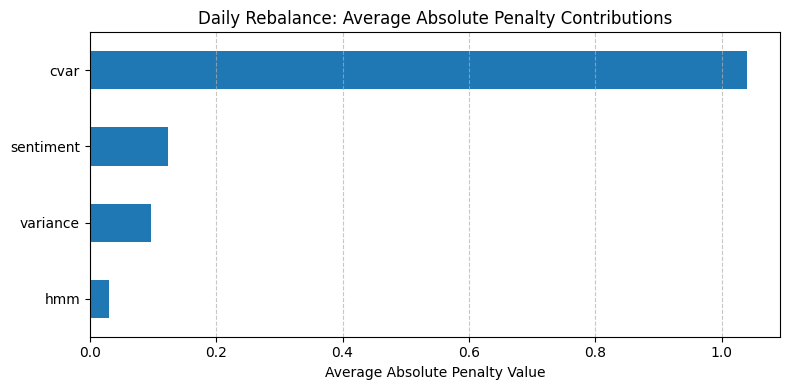

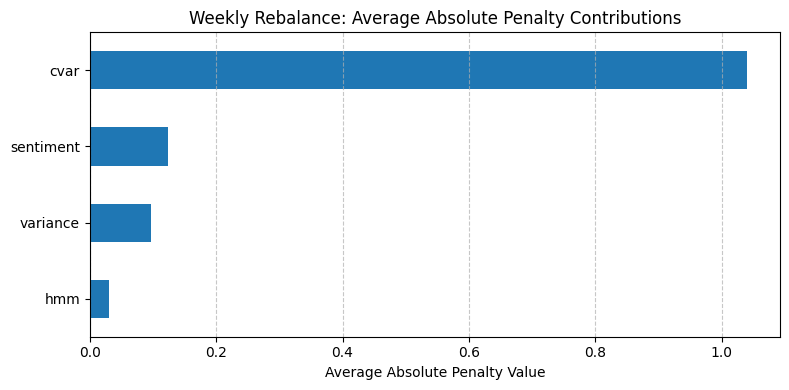

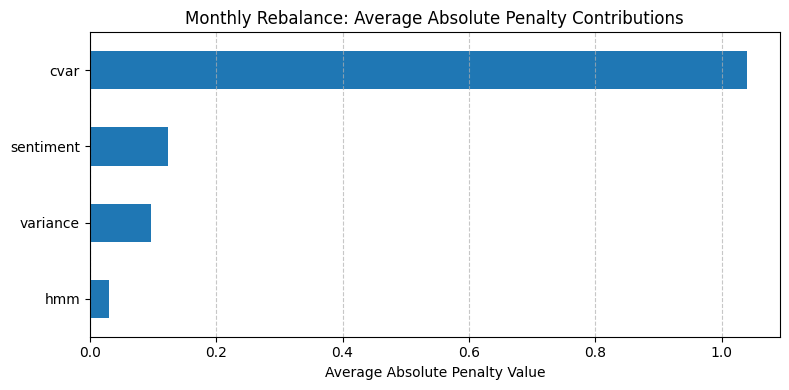

In [39]:
# After simulate_portfolio for, say, daily:
plot_penalty_ranking(logs, "Daily Rebalance")
plot_penalty_ranking(logs, "Weekly Rebalance")
plot_penalty_ranking(logs, "Monthly Rebalance")
